# Imports

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights, alexnet, AlexNet_Weights
from torch.utils.data import Dataset
from torchvision.datasets import CIFAR10
from torchvision import transforms
import numpy as np
import torch.nn.functional as F

# Part A

## Load model, dataset, data loader

I'm setting up a binary classifier using the AlexNet architecture to be trained on the CIFAR10 dataset. I start with pre-trained weights and freeze all parameters. Then, I replace the last layer of the classifier to output two classes instead of the original number, and set only the parameters of this classifier to be trainable. I load the CIFAR10 dataset and filter it to only include images of airplanes and cars, which I then use to train the modified AlexNet model.

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


weights = AlexNet_Weights.DEFAULT
model = alexnet(weights=weights)

# freeze the params
for param in model.parameters():
    param.requires_grad = False


model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)


for param in model.classifier.parameters():
    param.requires_grad = True


transform = weights.transforms()

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


trainset.targets = torch.tensor(trainset.targets)
mask = (trainset.targets == classes.index('plane')) | (trainset.targets == classes.index('car'))
trainset.data = trainset.data[mask.numpy()]
trainset.targets = trainset.targets[mask]

trainloader_classifier = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Train fully connected layers (classifier)

I then move the model to the GPU if available and define a loss function and an optimizer. I train the model for 10 epochs, during which I calculate and keep track of the loss and accuracy for each epoch. After the training is complete, I plot the loss and accuracy values over the epochs to visualize how the training progressed.

Epoch 1, Loss: 0.19168635757912875, Accuracy: 94.11%
Epoch 2, Loss: 0.08142536337588244, Accuracy: 97.01%
Epoch 3, Loss: 0.07179417563928588, Accuracy: 97.55%
Epoch 4, Loss: 0.07183425787874871, Accuracy: 97.6%
Epoch 5, Loss: 0.05894058242782796, Accuracy: 98.07%
Epoch 6, Loss: 0.0514646253096619, Accuracy: 98.3%
Epoch 7, Loss: 0.03695263053145212, Accuracy: 98.67%
Epoch 8, Loss: 0.033865550816907945, Accuracy: 98.7%
Epoch 9, Loss: 0.03820372753186238, Accuracy: 98.74%
Epoch 10, Loss: 0.028315960745604645, Accuracy: 99.03%
Finished Training


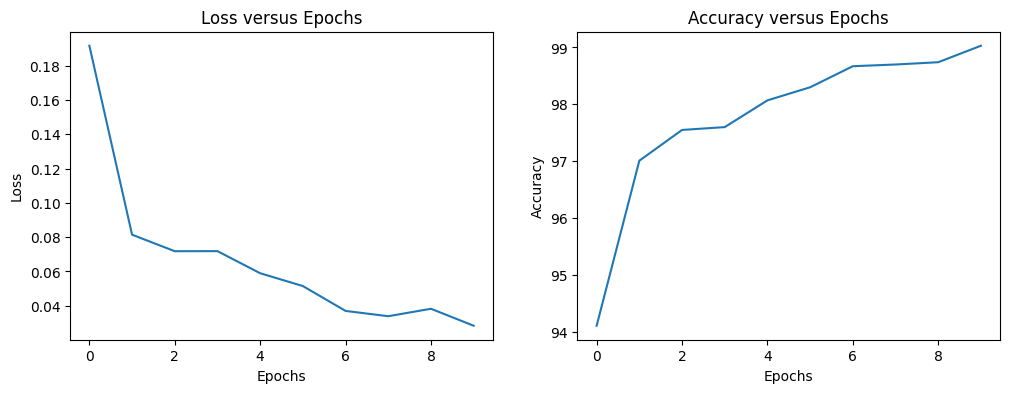

In [ ]:

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


model.train()
loss_values = []
accuracy_values = []
for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader_classifier, 0):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    loss_values.append(running_loss / len(trainloader_classifier))
    accuracy_values.append(100 * correct / total)
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader_classifier)}, Accuracy: {100 * correct / total}%')

print('Finished Training')


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_values)
plt.title('Loss versus Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracy_values)
plt.title('Accuracy versus Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Test model

 I load and normalize the CIFAR10 test dataset, filtering it to only include images of airplanes and cars. I then run the model in evaluation mode on this test data, calculating the number of correct predictions to determine the model’s accuracy.

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testset.targets = torch.tensor(testset.targets)
mask = (testset.targets == classes.index('plane')) | (testset.targets == classes.index('car'))
testset.data = testset.data[mask.numpy()]
testset.targets = testset.targets[mask]

testloader_classifier = torch.utils.data.DataLoader(testset, batch_size=512,
                                         shuffle=False)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader_classifier:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


Files already downloaded and verified
Accuracy of the network on the test images: 97 %


# Part B

# Required Classes

I define a custom loss function, TripletLoss, which calculates the triplet loss for a given anchor, positive, and negative sample. This loss encourages the model to learn embeddings such that the distance between the anchor and the positive sample is less than the distance between the anchor and the negative sample by a certain margin. I also create a custom dataset, TripletCIFAR10, which loads the CIFAR10 dataset and filters it to only include images of airplanes and cars. It overrides the __getitem__ method to return a triplet of an anchor, a positive sample, and a negative sample for training the model with triplet loss.

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive, 2)
        distance_negative = F.pairwise_distance(anchor, negative, 2)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()


class TripletCIFAR10(Dataset):
    def __init__(self, root, transform=None, download=False):
        self.cifar10 = CIFAR10(root, train=True, transform=transform, download=download)

        mask = (np.array(self.cifar10.targets) == 0) | (np.array(self.cifar10.targets) == 1)

        self.cifar10.data = self.cifar10.data[mask]
        self.cifar10.targets = np.array(self.cifar10.targets)[mask]
        self.indices = self.get_indices()

    def get_indices(self):
        plane_indices = np.where(self.cifar10.targets == 0)[0]
        car_indices = np.where(self.cifar10.targets == 1)[0]
        return plane_indices, car_indices

    def __getitem__(self, index):
        anchor = self.cifar10[index][0]

        plane_indices, car_indices = self.indices
        label = self.cifar10[index][1]

        if np.any(np.isin(plane_indices, index)):
          random_index_plane = np.random.choice(plane_indices)
          random_index_car = np.random.choice(car_indices)
          positive = self.cifar10[random_index_plane][0]
          negative = self.cifar10[random_index_car][0]

        else:
          random_index_plane = np.random.choice(plane_indices)
          random_index_car = np.random.choice(car_indices)
          negative = self.cifar10[random_index_plane][0]
          positive = self.cifar10[random_index_car][0]

        return anchor, positive, negative, label

    def __len__(self):
        return len(self.indices[0]) + len(self.indices[1])




In [ ]:
for param in model.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = False

batch_size = 64
trainset = TripletCIFAR10(root='root', transform=weights.transforms(), download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

100%|██████████| 170498071/170498071 [00:04<00:00, 41737491.18it/s]


Extracting root/cifar-10-python.tar.gz to root


## Train feature extractor

After defining the custom `TripletLoss` function as the loss criterion and setting up the optimizer, I proceed to train the model. I loop over the dataset for 10 epochs, during each of which I calculate the triplet loss for each batch of anchor, positive, and negative samples and update the model parameters accordingly. I keep track of the loss for each epoch and, after training, plot the loss values over the epochs to visualize how the model's performance improved during training.

Epoch 1, Loss: 1.0003304086673033
Epoch 2, Loss: 0.6755712596094532
Epoch 3, Loss: 0.40273672987701026
Epoch 4, Loss: 0.300650745820088
Epoch 5, Loss: 0.25091228292436357
Epoch 6, Loss: 0.21132082838541383
Epoch 7, Loss: 0.17078057183012083
Epoch 8, Loss: 0.15299951455965163
Epoch 9, Loss: 0.13132812239372046
Epoch 10, Loss: 0.11101436311272299
Finished Training


Text(0, 0.5, 'Loss')

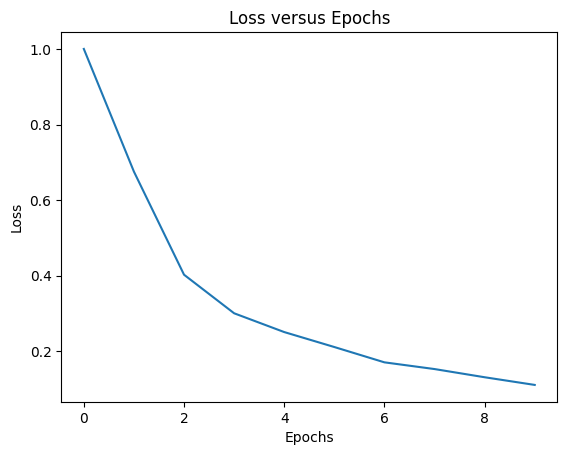

In [ ]:

criterion = TripletLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


model.train()
loss_values = []
accuracy_values = []
for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        anchors, positives, negatives = data
        anchors = anchors.to(device)
        positives = positives.to(device)
        negatives = negatives.to(device)


        optimizer.zero_grad()

        combined_batch = torch.cat((anchors, positives, negatives), dim=0)
        outputs = model.features(combined_batch)
        anchor_out, positive_out, negative_out = torch.split(outputs, len(anchors), dim=0)


        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()

    loss_values.append(running_loss / len(trainloader))
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')

print('Finished Training')

plt.plot(loss_values)
plt.title('Loss versus Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

## Train classifier after feature extraction

After training the model with the triplet loss, I freeze all the parameters of the model and only unfreeze the parameters of the fully connected layer. I then define a new loss function, the cross-entropy loss, and an optimizer. I train the model for 10 epochs on the binary classification task, keeping track of the loss and accuracy for each epoch. After training, I plot the loss and accuracy values over the epochs to visualize the training progress.

Epoch 1, Loss: 0.18126351151952685, Accuracy: 98.14%
Epoch 2, Loss: 0.04433365000247283, Accuracy: 99.1%
Epoch 3, Loss: 0.038372055777770246, Accuracy: 99.14%
Epoch 4, Loss: 0.05873670875414122, Accuracy: 99.06%
Epoch 5, Loss: 0.16151682517701163, Accuracy: 99.09%
Epoch 6, Loss: 0.19992931894712795, Accuracy: 98.99%
Epoch 7, Loss: 0.17232097696527374, Accuracy: 99.06%
Epoch 8, Loss: 0.09863529075996605, Accuracy: 99.11%
Epoch 9, Loss: 0.1475891331904001, Accuracy: 99.17%
Epoch 10, Loss: 0.0989817974690313, Accuracy: 99.39%
Finished Training


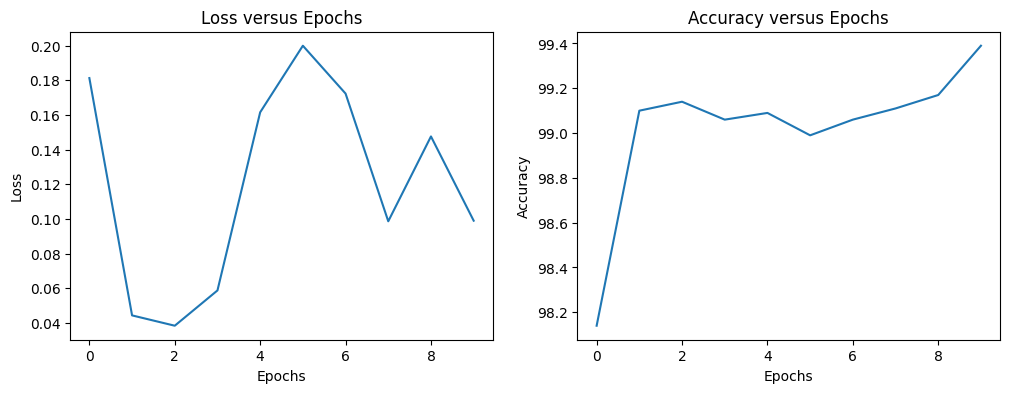

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


model.train()
loss_values = []
accuracy_values = []
for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader_classifier, 0):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    loss_values.append(running_loss / len(trainloader_classifier))
    accuracy_values.append(100 * correct / total)
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader_classifier)}, Accuracy: {100 * correct / total}%')

print('Finished Training')


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_values)
plt.title('Loss versus Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracy_values)
plt.title('Accuracy versus Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Test model after feature extraction

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader_classifier:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 96 %


# Part C

## Train model with sum of two loss functions

In the next step, I unfreeze all the parameters of the model and define two loss functions: the custom `TripletLoss` and the `CrossEntropyLoss`. I then train the model for 10 epochs on the binary classification task using both loss functions. The `TripletLoss` is calculated using the features of the anchor, positive, and negative samples, while the `CrossEntropyLoss` is calculated using the outputs of the model and the labels. I keep track of the loss and accuracy for each epoch. After training, I plot the loss and accuracy values over the epochs to visualize the training progress.

Files already downloaded and verified
Epoch 1, Loss: 0.15568470665413864, Accuracy: 99.24%
Epoch 2, Loss: 0.15324611660496446, Accuracy: 99.2%
Epoch 3, Loss: 0.16689140707918793, Accuracy: 99.21%
Epoch 4, Loss: 0.16080094703063844, Accuracy: 99.19%
Epoch 5, Loss: 0.22684536065170718, Accuracy: 99.11%
Epoch 6, Loss: 0.14434750989126932, Accuracy: 99.33%
Epoch 7, Loss: 0.17040661907499763, Accuracy: 99.29%
Epoch 8, Loss: 0.13415143496481477, Accuracy: 99.42%
Epoch 9, Loss: 0.1934225337140879, Accuracy: 99.28%
Epoch 10, Loss: 0.18081566121927492, Accuracy: 99.32%
Finished Training


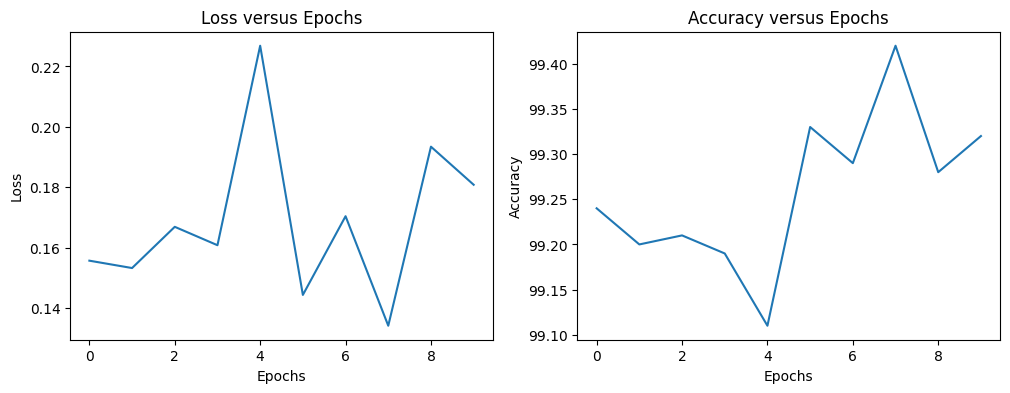

In [ ]:
batch_size = 64
trainset = TripletCIFAR10(root='root', transform=weights.transforms(), download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

for param in model.parameters():
    param.requires_grad = True


criterion = nn.CrossEntropyLoss()
criterion2 = TripletLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


model.train()
loss_values = []
accuracy_values = []
for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        anchors, positives, negatives, labels = data
        anchors = anchors.to(device)
        positives = positives.to(device)
        negatives = negatives.to(device)
        labels = labels.to(device)


        optimizer.zero_grad()

        combined_batch = torch.cat((anchors, positives, negatives), dim=0)
        features = model.features(combined_batch)

        anchor_out, positive_out, negative_out = torch.split(features, len(anchors), dim=0)


        outputs = model(anchors)
        loss = criterion2(anchor_out, positive_out, negative_out) + criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    loss_values.append(running_loss / len(trainloader))
    accuracy_values.append(100 * correct / total)
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, Accuracy: {100 * correct / total}%')

print('Finished Training')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_values)
plt.title('Loss versus Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracy_values)
plt.title('Accuracy versus Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()



## Test model

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader_classifier:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 96 %
